# LeNet

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import transforms, utils
from PIL import Image
import os
import pickle

In [2]:
def img_load(path):
    img = Image.open(path).convert('RGB')
    return img

In [3]:
def img_show(img):
    plt.imshow(img)
    plt.show()

In [4]:
file_path = 'x_train/'
img_number = 0
for i in os.listdir(file_path):
    if '.png' in i:
        img_number += 1
print(img_number)

60000


In [5]:
X_train = list()
for i in range(img_number):
    img_path = 'x_train/%s.png' % str(i)
    img = img_load(img_path)
    X_train.append(img)
print(len(X_train))

60000


In [6]:
with open("x_train.txt", "wb") as fp:
    pickle.dump(X_train, fp)

In [7]:
with open("x_train.txt", "rb") as fp:
    X_train = pickle.load(fp)

In [8]:
file_path = 'x_test/'
img_number = 0
for i in os.listdir(file_path):
    if '.png' in i:
        img_number += 1
print(img_number)

10000


In [9]:
X_test = list()
for i in range(img_number):
    img_path = 'x_test/%s.png' % str(i)
    img = img_load(img_path)
    X_test.append(img)
print(len(X_test))

10000


In [10]:
with open("x_test.txt", "wb") as fp:
    pickle.dump(X_test, fp)

In [11]:
y_train = np.load('../y_train.npy') 
y_train = y_train.tolist()
print(len(y_train))

60000


In [12]:
with open("y_train.txt", "wb") as fp:
    pickle.dump(y_train, fp)

In [13]:
y_test = np.load('../y_test.npy') 
y_test = y_test.tolist()
print(len(y_test))

10000


In [14]:
with open("y_test.txt", "wb") as fp:
    pickle.dump(y_test, fp)

In [16]:
class ListData(Dataset):
    
    def __init__(self, X_list, y_list, transform):
        self.X_list = X_list
        self.y_list = y_list
        self.transform = transform
        if len(self.X_list) == len(self.y_list):
            print('len(X_list) == len(y_list)')
        else:
            print('len(X_list) != len(y_list)')
        print('transform: %s' % self.transform)
            
    def __getitem__(self, index):
        if self.transform != None:
            X = self.transform(self.X_list[index])
            y = self.y_list[index]
        return X, y
    
    def __len__(self):
        return len(self.y_list)

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

In [18]:
data_train = ListData(X_train, y_train, transform)
print(len(data_train))

len(X_list) == len(y_list)
transform: Compose(
    ToTensor()
)
60000


In [19]:
data_test = ListData(X_test, y_test, transform)
print(len(data_test))

len(X_list) == len(y_list)
transform: Compose(
    ToTensor()
)
10000


In [20]:
data_loader_train = torch.utils.data.DataLoader(
    dataset=data_train,
    batch_size=64,
    shuffle=True,
)

In [21]:
data_loader_test = torch.utils.data.DataLoader(
    dataset=data_test,
    batch_size=64,
    shuffle=True,
)

tensor([7, 4, 6, 0, 9, 3, 6, 8, 6, 1, 1, 9, 7, 3, 2, 0, 5, 7, 6, 8, 8, 3, 2, 5,
        7, 6, 0, 8, 9, 8, 7, 4, 0, 7, 9, 0, 8, 8, 2, 7, 3, 3, 3, 9, 6, 2, 8, 9,
        8, 6, 3, 5, 8, 7, 5, 0, 3, 9, 1, 0, 3, 3, 2, 1])


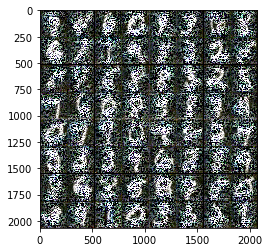

In [22]:
for data in data_loader_test:
    X_test, y_test = data
    print(y_test)
    img = torchvision.utils.make_grid(X_test) 
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.show()
    break

In [32]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(            
            nn.Conv2d(3, 6, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),            
        )
        self.classifier = nn.Sequential(
            nn.Linear(61504, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, 10),            
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

model = LeNet()
print(model)

LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=61504, out_features=120, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [33]:
if torch.cuda.is_available():
    print('cuda')
    model.cuda()

cuda


In [34]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 20
for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = Variable(X_train).cuda(), Variable(y_train).cuda()
        outputs = model(X_train) 
        pred = torch.max(outputs.data, 1)[1]
        optimizer.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0].item()
        running_correct += torch.sum(pred==y_train.data).item()
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test, y_test = Variable(X_test).cuda(), Variable(y_test).cuda()
        outputs = model(X_test)
        pred = torch.max(outputs.data, 1)[1]
        testing_correct += torch.sum(pred==y_test.data).item()
    print('epoch: %s' % (str(epoch + 1)))
    print('loss: %s' % str(running_loss / len(data_train)))
    print('training accuracy: %s' % str(running_correct / len(data_train)))
    print('testing accracy: %s' % str(testing_correct / len(data_test))) 
    print()

/home/iis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


epoch: 1
loss: 0.006011712494057913
training accuracy: 0.87475
testing accracy: 0.9524

epoch: 2
loss: 0.0019035367796197535
training accuracy: 0.9631666666666666
testing accracy: 0.954

epoch: 3
loss: 0.0006390862802043557
training accuracy: 0.98715
testing accracy: 0.9545

epoch: 4
loss: 0.0003210503352805972
training accuracy: 0.99335
testing accracy: 0.9529

epoch: 5
loss: 0.00023586391961822906
training accuracy: 0.9946666666666667
testing accracy: 0.9584

epoch: 6
loss: 0.0002127517086143295
training accuracy: 0.99545
testing accracy: 0.9567

epoch: 7
loss: 0.00016887839802851278
training accuracy: 0.9963833333333333
testing accracy: 0.9505

epoch: 8
loss: 0.00019114091911663612
training accuracy: 0.9958333333333333
testing accracy: 0.9552

epoch: 9
loss: 0.00016529438563932976
training accuracy: 0.9963833333333333
testing accracy: 0.9568

epoch: 10
loss: 0.0001003478912015756
training accuracy: 0.9978666666666667
testing accracy: 0.9547

epoch: 11
loss: 0.00014020095566908517
tr

In [36]:
torch.save(model, 'models/LeNet')
model = torch.load('models/LeNet')
print(model)

/home/iis/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=61504, out_features=120, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)
